In [1]:
import pandas as pd

# Load the multi-batch dataset
df_multi = pd.read_csv("multi_batch_channels_dataset.csv")

# Compute per-batch mean, std, CV
batch_summary = df_multi.groupby("batch_id")["measured_flow_mL_per_min"].agg(["mean", "std"])
batch_summary["cv"] = batch_summary["std"] / batch_summary["mean"]

print("Batch-level summary:")
print(batch_summary.head())


Batch-level summary:
               mean       std        cv
batch_id                               
BATCH_001  0.373844  0.045291  0.121149
BATCH_002  0.063912  0.003787  0.059255
BATCH_003  6.468637  0.602202  0.093096
BATCH_004  0.273139  0.022820  0.083546
BATCH_005  1.438789  0.159296  0.110715


In [2]:
# Select features (fixed per batch)
features = [
    "resin_type", "layer_thickness_um", "orientation_deg",
    "support_mode", "fit_adjustment_pct",
    "channel_length_mm", "channel_diameter_mm", "channel_width_mm"
]

# Merge batch-level CV back with batch parameters
df_batches = df_multi.groupby("batch_id").first()[features].reset_index()
df_batches = df_batches.merge(batch_summary["cv"].reset_index(), on="batch_id")

print("Prepared dataset:", df_batches.shape)
df_batches.head()


Prepared dataset: (20, 10)


,batch_id,resin_type,layer_thickness_um,orientation_deg,support_mode,fit_adjustment_pct,channel_length_mm,channel_diameter_mm,channel_width_mm,cv
0,BATCH_001,Resin_C,20,45,manual,0.395,26.241,0.812,1.174,0.121149
1,BATCH_002,Resin_B,100,45,manual,0.057,43.697,0.593,2.823,0.059255
2,BATCH_003,Resin_B,50,30,manual,-1.261,58.783,2.050,3.818,0.093096
3,BATCH_004,Resin_C,20,0,auto,1.948,50.890,0.897,1.017,0.083546
4,BATCH_005,Resin_A,100,60,manual,-0.901,42.450,1.266,3.915,0.110715


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

X = df_batches[features]
y = df_batches["cv"]

categorical = ["resin_type", "support_mode"]
numerical = [f for f in features if f not in categorical]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", "passthrough", numerical)
])

model = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

print("Surrogate model R² on test set:", model.score(X_test, y_test))


Surrogate model R² on test set: -0.28501810408635064


In [4]:
from bayes_opt import BayesianOptimization

# Define parameter search space
pbounds = {
    "layer_thickness_um": (20, 100),
    "orientation_deg": (0, 90),
    "fit_adjustment_pct": (-2.0, 2.0),
    "channel_length_mm": (20, 60),
    "channel_diameter_mm": (0.5, 2.5),
    "channel_width_mm": (1.0, 4.0)
}

def objective(**params):
    row = pd.DataFrame([params])
    # Default categorical values (can expand pbounds to include these later)
    row["resin_type"] = "Resin_A"
    row["support_mode"] = "auto"
    pred_cv = model.predict(row)[0]
    return -pred_cv   # minimize CV


In [5]:
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=20)

print("Best parameters found:", optimizer.max["params"])
print("Lowest predicted CV:", -optimizer.max["target"])


|   iter    |  target   | layer_... | orient... | fit_ad... | channe... | channe... | channe... |
-------------------------------------------------------------------------------------------------
| 1         | -0.079687 | 49.963209 | 85.564287 | 0.9279757 | 43.946339 | 0.8120372 | 1.4679835 |
| 2         | -0.079834 | 24.646688 | 77.955853 | 0.4044600 | 48.322903 | 0.5411689 | 3.9097295 |
| 3         | -0.101721 | 86.595411 | 19.110519 | -1.272700 | 27.336180 | 1.1084844 | 2.5742692 |
| 4         | -0.091622 | 54.555601 | 26.210622 | 0.4474115 | 25.579754 | 1.0842892 | 2.0990855 |
| 5         | -0.082592 | 56.485598 | 70.665836 | -1.201304 | 40.569377 | 1.6848291 | 1.1393512 |
| 6         | -0.085226 | 20.0      | 90.0      | -2.0      | 20.0      | 2.5       | 1.0       |
| 7         | -0.090457 | 100.0     | 90.0      | 2.0       | 60.0      | 0.7078701 | 4.0       |
| 8         | -0.076836 | 49.909990 | 84.679383 | 2.0       | 42.618397 | 0.5       | 1.8840531 |
| 9         | -0.081

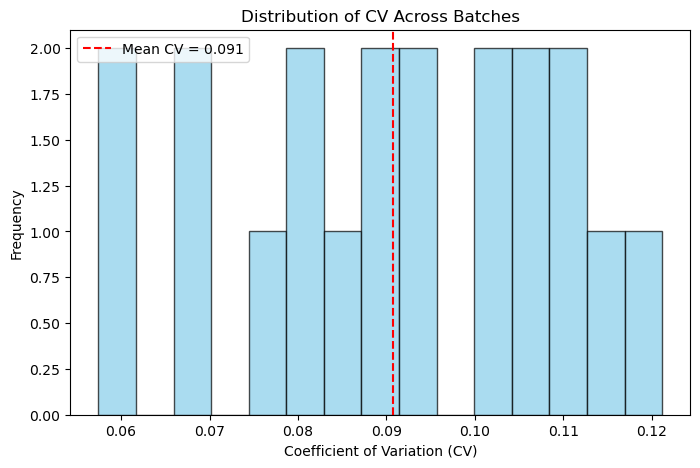

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df_batches["cv"], bins=15, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(df_batches["cv"].mean(), color="red", linestyle="--", label=f"Mean CV = {df_batches['cv'].mean():.3f}")
plt.title("Distribution of CV Across Batches")
plt.xlabel("Coefficient of Variation (CV)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


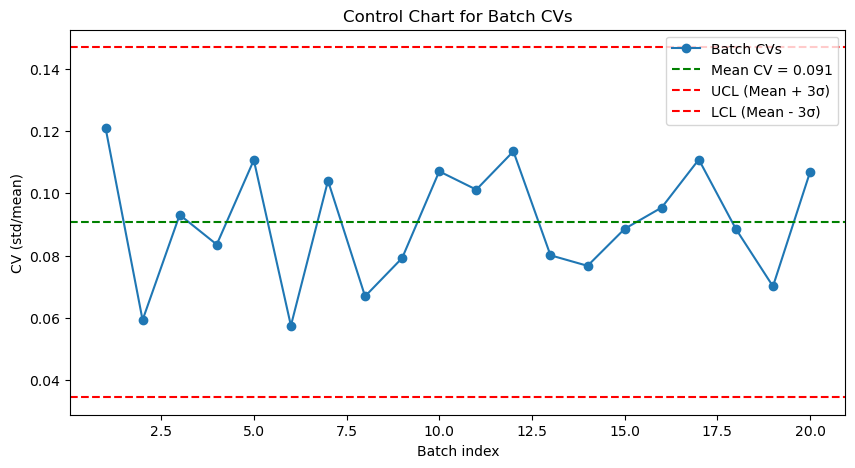

In [7]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(df_batches)+1), df_batches["cv"], marker="o", linestyle="-", label="Batch CVs")
plt.axhline(df_batches["cv"].mean(), color="green", linestyle="--", label=f"Mean CV = {df_batches['cv'].mean():.3f}")
plt.axhline(df_batches["cv"].mean() + 3*df_batches["cv"].std(), color="red", linestyle="--", label="UCL (Mean + 3σ)")
plt.axhline(df_batches["cv"].mean() - 3*df_batches["cv"].std(), color="red", linestyle="--", label="LCL (Mean - 3σ)")
plt.title("Control Chart for Batch CVs")
plt.xlabel("Batch index")
plt.ylabel("CV (std/mean)")
plt.legend()
plt.show()
